**Описание проекта**

У фитнес-центра есть проблема оттока клиентов. На основе клиентских анкет нужно провести анализ и подготовить план действий по удержанию клиентов.
А именно:
научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
проанализировать основные признаки, наиболее сильно влияющие на отток;
сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
1) выделить целевые группы клиентов;

2) предложить меры по снижению оттока;

3) определить другие особенности взаимодействия с клиентами.

## Шаг. Загрузка данных

In [1]:
# импорт библиотек
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# чтение файла
df = pd.read_csv('gym_churn.csv')
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Посмотрю поброднее методом info()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

В таблице 14 колонок с разными признаками. Пропусков нет. Данные целочисленного и вещественного типа.

### Общий вывод по шагу 1


При первоначальном просмотре можно сообщить, что датасет включает 4000 строк в 14 колонках. В колонках указаны раличные данные клиентов (признаки, по которым в дальнейшем будет строится модель обучения). Большая часть признаком целочисленного типа данных, и можно сказать, что для некоторых это бинарное значение - сообщает факт (да/нет) о, к примеру, проживании или работе рядом с фитнес-центром, наличии контактного телефона, является ли сотрудником компаниии-партнера. Данные типа float содержатся в четырех колонках, три из которых - средние по частоте посещений в неделю за все время, за предыдущий месяц, а также среднее по суммарной выручке от доп услуг фитнес-центра. Четвертая флот колонка - срок до окончания текущего абонемента в месяцах.

## Шаг. Исследовательский анализ данных (EDA)

### Проверка на пропуски и дубликаты

Проверю датасет на пропуски и дубликаты методами isna() и duplicated() соответственно

In [4]:
df.isna().sum()

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

Пропусков значений нет. Это также сообщал ранее метод info()

In [5]:
df.duplicated().sum()

0

Полные дубликаты отсутсвуют

Рассмотрю побробнее значения признаков. Применяю describe()

In [6]:
df.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


В описании не было подробного описания значений в колонке gender. Предполагаю, что 0 - мужчина, 1 - женщина. По среднему тогда можно сделать вывод, что среди клиентов немного больше женщин. Так как в большинстве колонок значения 0 и 1, минимум и максимум - 0 и 1 соответственно. В колонке churn(отток) в значении среднего 0.26. Это значит из 4000 клиентов в 26% случаев было значение 1 (т.е. да) по факту отток (клиент ушел).

Внимательнее рассмотрю признаки тех, кто ушел и остался

In [7]:
df.groupby('Churn').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


В среднем те, кто покинули клуб, реже являются сотрудником компании-партнера, реже ходят на групповые занятия, а по средним посещениям у группы оттока снижение от посещений за год к посещения за последний месяц почти на 0.5. Для сравнения у группы посещающих (0) этот показатель без изменений. Замечу также, что возраст в группе оттока ниже - в среднем на три года моложе, чем в группе посещающих. Такие значения как пол или наличие контактного телефона не влияют, в обеих группах это примерно одинаковое значение.

### Гистограммы распределения по признакам

Построю гистрогаммы распределения методом distplot() библиотеки seaborn

D:\Study\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


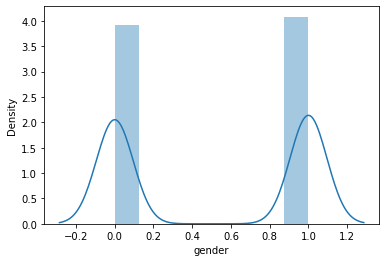

D:\Study\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


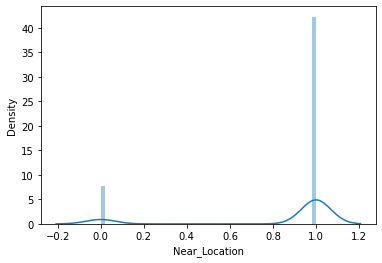

D:\Study\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


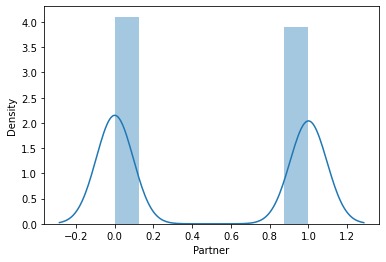

D:\Study\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


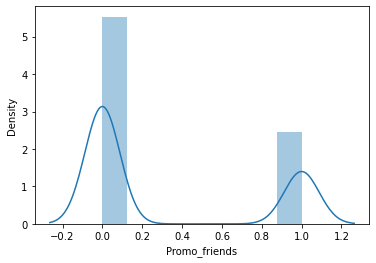

D:\Study\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


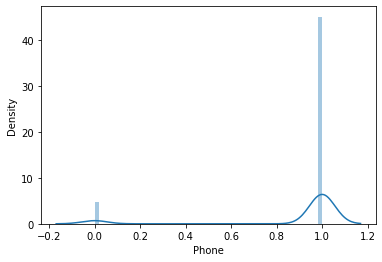

D:\Study\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


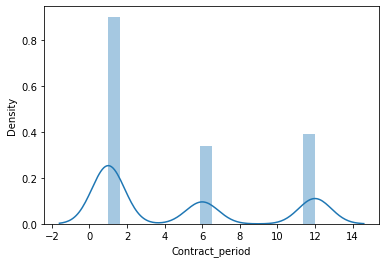

D:\Study\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


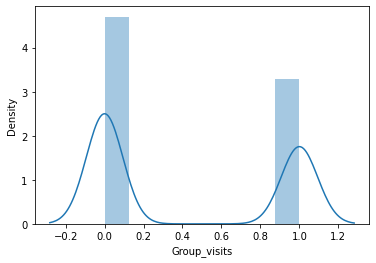

D:\Study\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


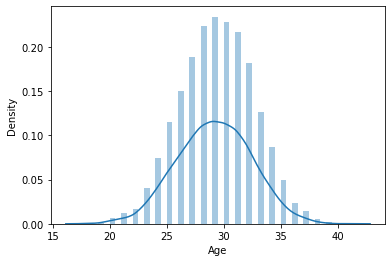

D:\Study\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


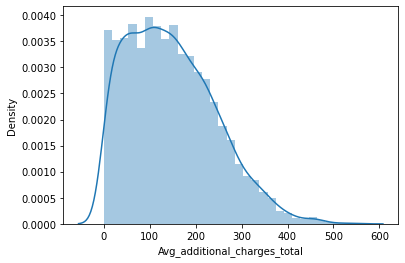

D:\Study\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


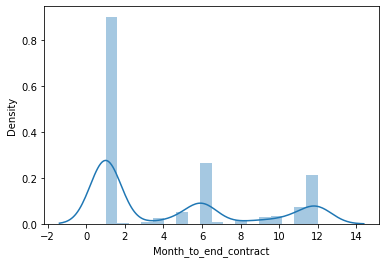

D:\Study\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


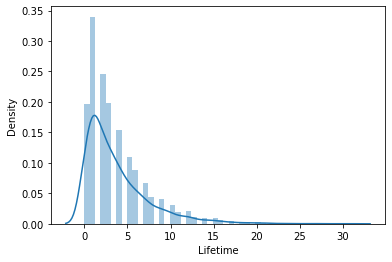

D:\Study\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


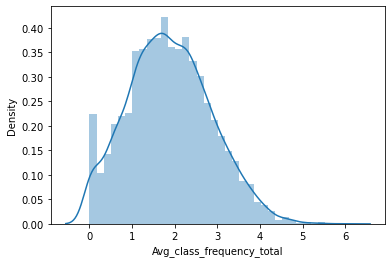

D:\Study\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


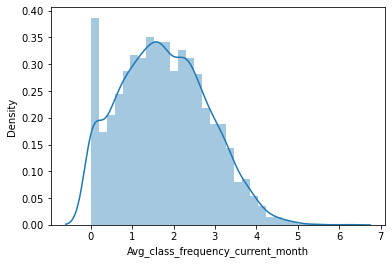

D:\Study\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


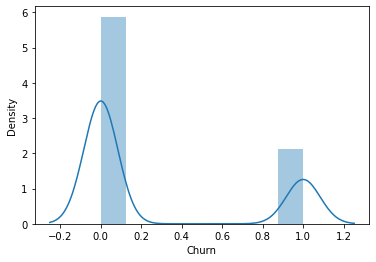

In [8]:
for feature in df.columns:
    sns.distplot(df[feature])
    plt.show() 

Признаков всего 14, однако в большинстве случаев это значение 0 и 1. На гистограмме распределения посещаемости есть явное отличие - все время и текущий месяц

Посмотрю на отдельные признаки, учитывая отток

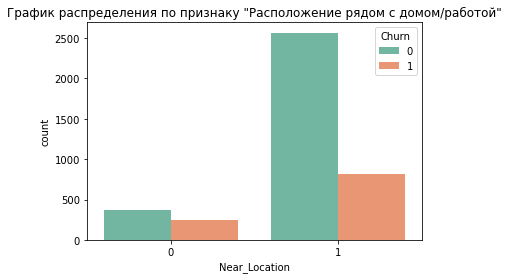

In [9]:
df_churn = df.query('Churn == 0')
df_non_churn = df.query('Churn == 1')

sns.countplot(x='Near_Location', hue='Churn', data=df, palette="Set2")
plt.title('График распределения по признаку "Расположение рядом с домом/работой"')
plt.show()


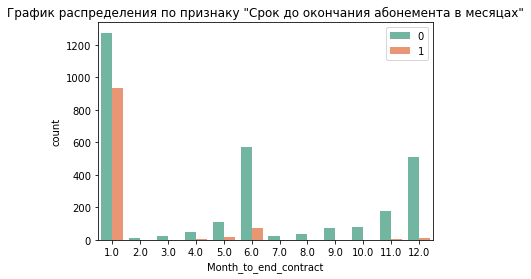

In [10]:
sns.countplot(x='Month_to_end_contract', hue='Churn', data=df, palette="Set2")
plt.title('График распределения по признаку "Срок до окончания абонемента в месяцах"')
plt.legend()
plt.show()

D:\Study\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Study\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


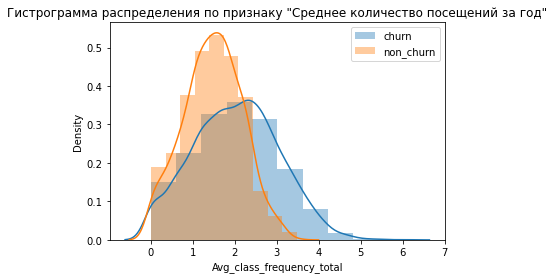

In [11]:
sns.distplot(df_churn['Avg_class_frequency_total'], label='churn', bins=10)
sns.distplot(df_non_churn['Avg_class_frequency_total'], label='non_churn',bins=10)
plt.title('Гистрограмма распределения по признаку "Среднее количество посещений за год"')
plt.legend()
plt.show()

D:\Study\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Study\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


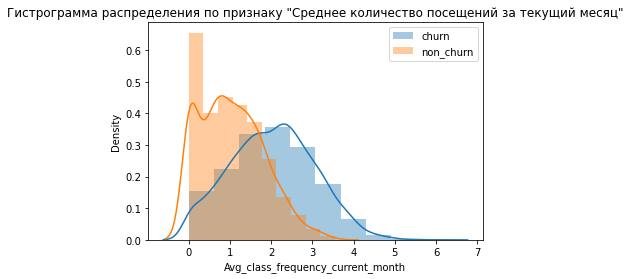

In [12]:
sns.distplot(df_churn['Avg_class_frequency_current_month'], label='churn', bins=10)
sns.distplot(df_non_churn['Avg_class_frequency_current_month'], label='non_churn',bins=10)
plt.title('Гистрограмма распределения по признаку "Среднее количество посещений за текущий месяц"')
plt.legend()
plt.show()

И по этим графикам можно сделать некоторые выводы:
- Группа оттока больше среди тех, у кого абонемент скоро заканчивается
- Чем меньше посещаемость за текущий месяц относительно общей посещаемости за все время, тем больше отток

### Таблица и карта корреляции признаков

In [13]:
cm = df.corr()
cm

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
Near_Location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
Partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
Promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
Phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
Contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
Group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
Age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
Avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
Month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


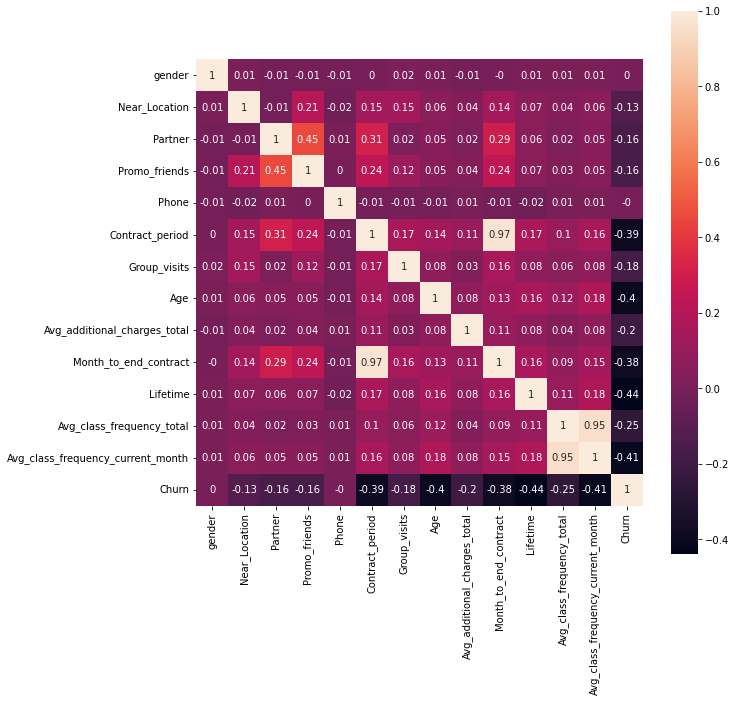

In [14]:
plt.subplots(figsize=(10,10))
ax = sns.heatmap(cm.round(2), annot=True, square=True)

По большинству признаков есть отрицательная корреляция с признаком отток(churn). При уменьшении/увеличении одного признака увеличивается/уменьшается другой. Полагаю, на примере можно выразить так: 

- При уменьшении контрактного периода абонемента уровень оттока растет (корреляция -0.39)
- Чем больше прошло времени с момента первого обращения в фитнес-центр, тем меньше отток (корреляция -0.44)
- Показатель корреляции изменяется почти в два раза от среднего количества посещений всего к среднему за текущий месяц (от -0.25 до -0.41)

Есть сильная попарная корреляция между 

- Срок до окончания абонемента - Период абонемента  (0.97)
- Средняя посещаемость за все время - Средняя посещаемость за текущий месяц (0.95)

Для построения модели лучше избавиться от мультиколлинеарности, например, удалить вручную один из двух из признаков, корреляция между которыми более 0.8


In [15]:
df.drop(columns=['Contract_period', 'Avg_class_frequency_total'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Group_visits                       4000 non-null   int64  
 6   Age                                4000 non-null   int64  
 7   Avg_additional_charges_total       4000 non-null   float64
 8   Month_to_end_contract              4000 non-null   float64
 9   Lifetime                           4000 non-null   int64  
 10  Avg_class_frequency_current_month  4000 non-null   float64
 11  Churn                              4000 non-null   int64

Столбцы удалены. Построю заново тепловую карту

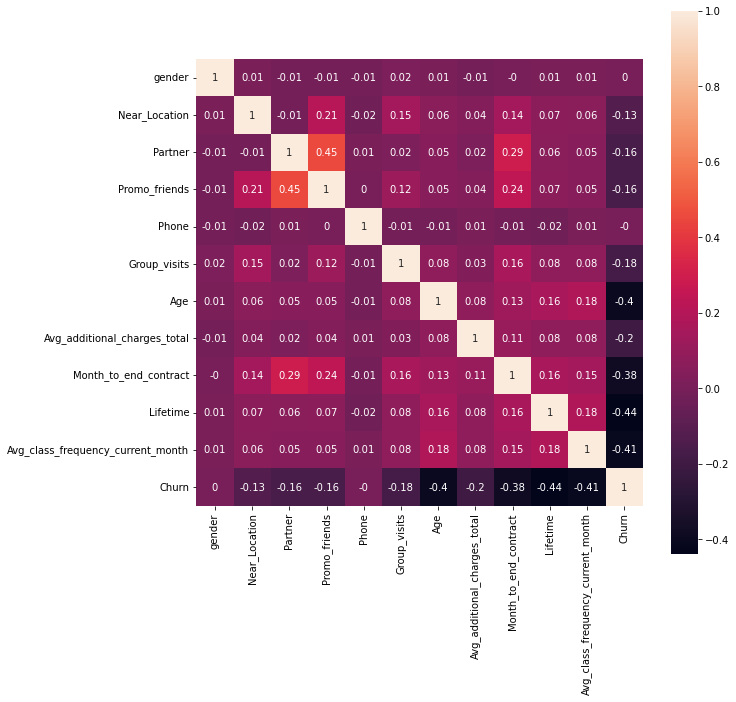

In [16]:
cm_new = df.corr()
plt.subplots(figsize=(10,10))
ax = sns.heatmap(cm_new.round(2), annot=True, square=True)

Таким образом, в таблице теперь нет высокой попарной корреляции

### Общий вывод по шагу 2

В шаге два был произведен исследовательский анализ, включающий
- Проверку на пропуски и дубликаты
- Построение гистограмм распредления признаков
- Построение таблицы и тепловой карты корреляции признаков

Можно сделать следующие предварительные выводы:
- В фитнес-центре решатестя проблема с оттоком клиентов. В таблице это признак churn. По нему и велись наблюдения. Он и будет в дальнейшем целевой переменной
- Гистограммы и корреляции показали разные уровни взаимосвязи у признаков. Сделаю предположение, что на отток клиентов в большей степени влияют такие признаки как средняя посещаемость за текущий месяц относительно общей средней посещаемости по клиенту, также срок до окончания абонемента, контрактный период.

## Шаг. Построение модели прогнозирования оттока клиентов

Для прогнозирования оттока подходит модель бинарной классификации, где целевой признак - отток клиентов в следующем месяце

### Разбиение данных на выборки

Методом train_test_split() разобьем выборки на обущающую (train) и валидационную (test)

In [17]:
#запишем признаки (матрица X) и целевую переменную (y)
X = df.drop('Churn', axis = 1)
y = df['Churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)


### Обучение модели

In [18]:
# задаем список моделей
models = [
    LogisticRegression(random_state=0),
    RandomForestClassifier(random_state=0)
    
]

# задаем функцию, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(
        'Accuracy:{:.2f} Precision:{:.2f} Recall:{:.2f} '.format(
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred),
        )
    )

### Оценка метрик

Применяю функцию и вывожу метрики

In [19]:
for i in models:
    print(i)
    make_prediction(
        m=i,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
    )

LogisticRegression(random_state=0)


D:\Study\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy:0.88 Precision:0.78 Recall:0.75 
RandomForestClassifier(random_state=0)
Accuracy:0.91 Precision:0.85 Recall:0.80 


### Общий вывод по шагу 3

Изучая показатели метрик классификации доля правильных ответов (accuracy), точность (precision) и полнота (recall), можно сделать вывод, что модель случайный лес показала себя лучше.

## Шаг. Кластеризация клиентов

### Стандартизация данных

In [20]:
 # создаём объект класса scaler (нормализатор)
scaler = StandardScaler()
#обучаем нормализатор и преобразуем данные
x_sc = scaler.fit_transform(df.drop(columns = ['Churn'])) 
x_sc

array([[ 0.97970588,  0.42788074,  1.02686062, ...,  0.16160501,
        -0.19332863, -1.67847198],
       [-1.0207145 ,  0.42788074, -0.973842  , ...,  1.83194105,
         0.87368001,  0.1360137 ],
       [-1.0207145 ,  0.42788074,  1.02686062, ..., -0.79287273,
        -0.46008079, -0.02901851],
       ...,
       [ 0.97970588,  0.42788074,  1.02686062, ...,  1.59332162,
        -0.46008079,  1.01103141],
       [-1.0207145 ,  0.42788074,  1.02686062, ...,  0.16160501,
        -0.19332863, -0.16225246],
       [ 0.97970588, -2.33709981,  1.02686062, ...,  1.83194105,
        -0.72683295, -0.69509885]])

После преобразования признаки в таблице в одном масштабе

### Матрица расстояний и дендрограмма

Применяю метод linkage() для построения матрицы расстояний

In [21]:
linked = linkage(x_sc, method = 'ward') 
linked

array([[5.47000000e+02, 3.88400000e+03, 1.11541554e-02, 2.00000000e+00],
       [1.46000000e+03, 1.53800000e+03, 2.48829986e-02, 2.00000000e+00],
       [2.36600000e+03, 3.42500000e+03, 2.93974563e-02, 2.00000000e+00],
       ...,
       [7.98700000e+03, 7.99500000e+03, 8.42095250e+01, 2.56600000e+03],
       [7.98300000e+03, 7.99600000e+03, 8.97776673e+01, 2.95200000e+03],
       [7.99200000e+03, 7.99700000e+03, 9.51876843e+01, 4.00000000e+03]])

Отрисую график дендрограмму

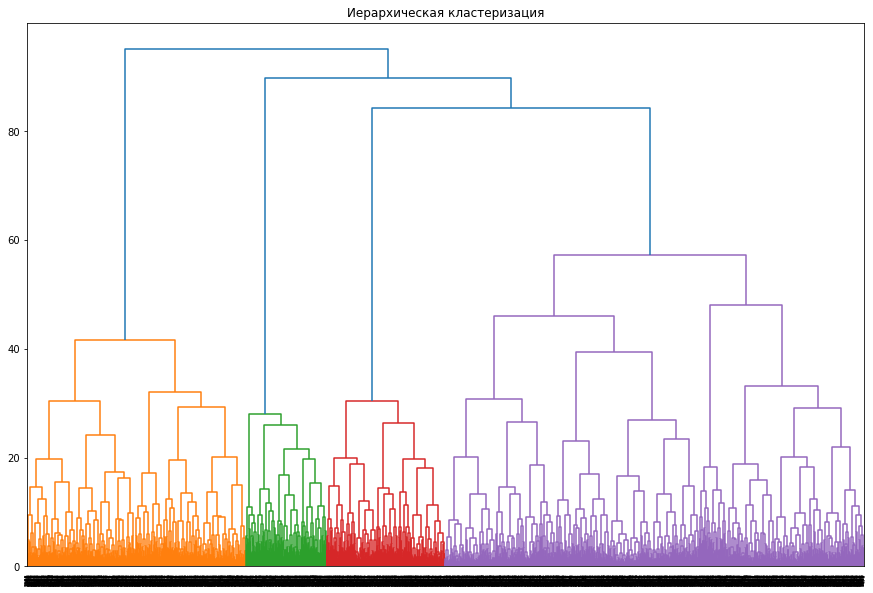

In [22]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show() 

На графике цветов: 4

Т.е. предложенное оптимальное число кластеров - 4

### K-means алгоритм для прогнозирования кластеров

Применяю метод K-means()

In [51]:
# задаём число кластеров и фиксируем значение random_state для воспроизводимости результата
km = KMeans(n_clusters=4, random_state=0) 
#прогнозируем кластеры для наблюдений на стандартизированной выборке
labels = km.fit_predict(x_sc) 

Сохраняю метки кластера в датасете

In [50]:
df['cluster_km'] = labels

### Средние значения признаков для кластеров

Посмотрю статистику по кластерам

In [38]:
clusters = df.groupby(['cluster_km']).mean().round(2)
clusters

,gender,Near_Location,Partner,Promo_friends,Phone,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_current_month,Churn
cluster_km,,,,,,,,,,,,
0,0.53,1.00,0.16,0.06,1.0,0.39,28.95,142.19,2.83,3.23,1.68,0.34
1,0.49,1.00,0.94,0.75,1.0,0.51,29.68,158.52,6.98,4.63,1.97,0.10
2,0.52,0.86,0.47,0.31,0.0,0.43,29.30,144.21,4.47,3.94,1.72,0.27
3,0.50,0.00,0.49,0.08,1.0,0.24,28.72,137.39,2.87,3.06,1.61,0.40


Обозначу кластеры согласно целевой переменной (по доле оттока): К34, К10, К27, К40

Особенности кластеров:

Для К34 характерно: клиенты моложе (не сильно), редко сотрудники компаний-партнеров, редко приходят по промо друзей, относительно стабильно посещают групповые тренировки по сравнению с другими кластерами

К10: клиенты старше(не сильно), очень часто сотрудники компаний_партнеров, чаще других приходят по промо друзей, больше всех тратят на дополнительные услуги фитнес-центра и больше других посещают групповые занятия. Также у них самый большой срок с момента первого обращения и самый большой срок до окончания абонемента

К27: По большинству показателей (возраст, промо друзей, компании-партнеры, групповые занятия) группа средняя между К10 и К34

К40: Больше походит на К34, но с более худшими показателями. Реже всех посещают групповые занятия, меньше всех тратят на дополнительные услуги, самый малый срок с момента первого обращения, самая низкая посещаемость

Переименую кластеры

In [39]:
def cluster_group (cluster_km):
    if cluster_km == 0:
        return 'K34'
    if cluster_km == 1:
        return 'K10'
    if cluster_km == 2:
        return 'K27'
    return 'K40'

In [40]:
df['cluster_group'] = df['cluster_km'].apply(cluster_group)


Отрисую попарные графики признаков с разметкой по кластерам

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


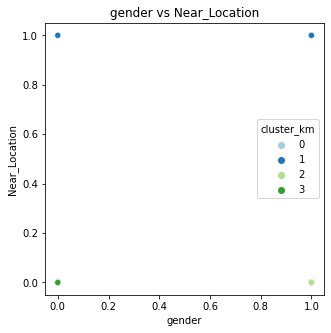

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


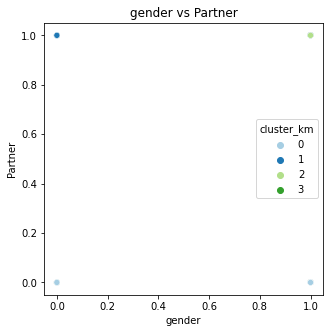

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


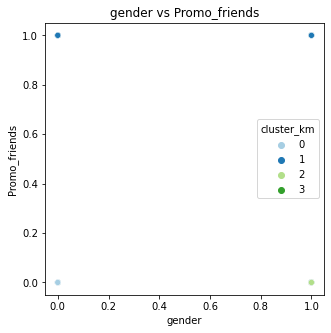

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


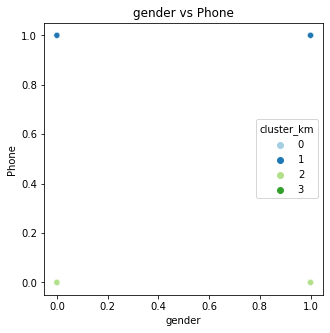

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


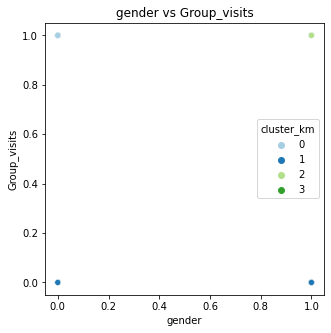

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


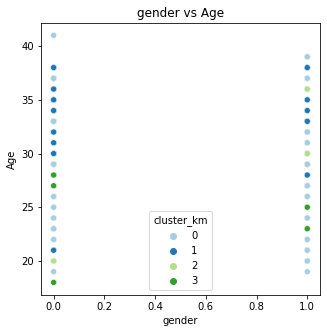

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


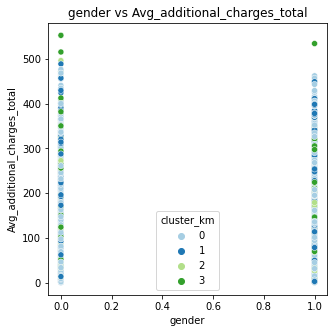

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


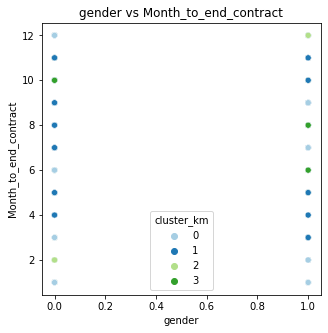

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


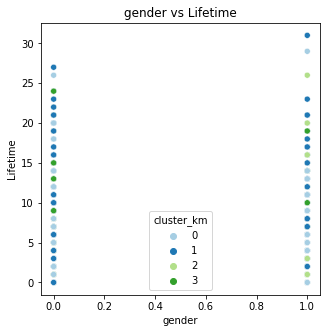

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


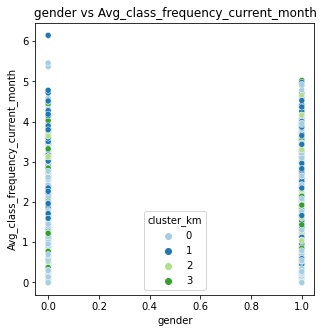

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


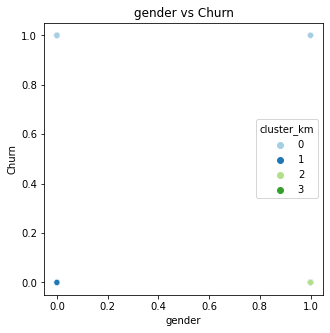

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


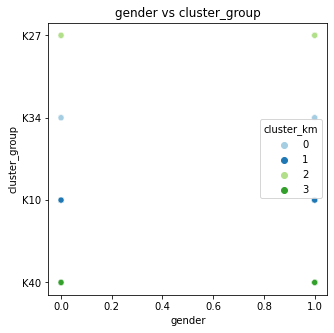

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


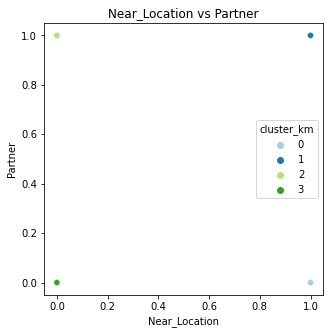

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


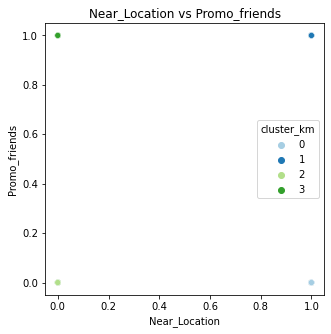

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


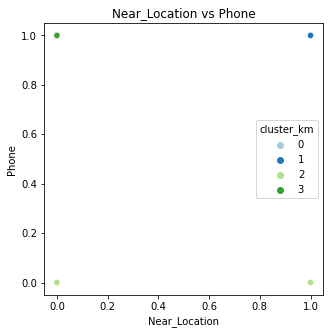

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


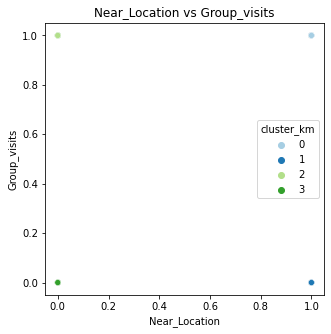

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


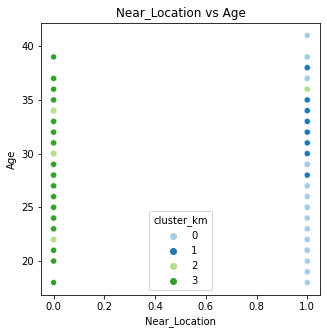

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


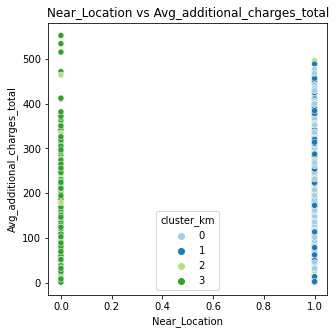

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


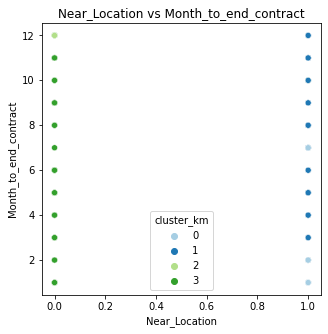

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


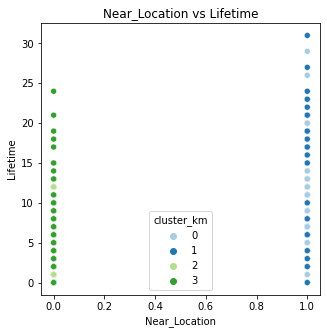

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


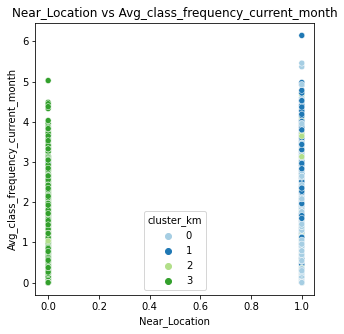

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


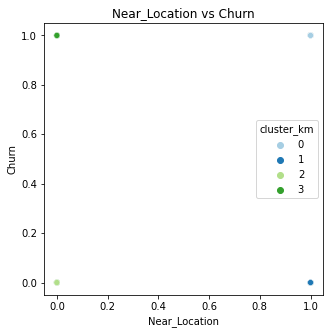

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


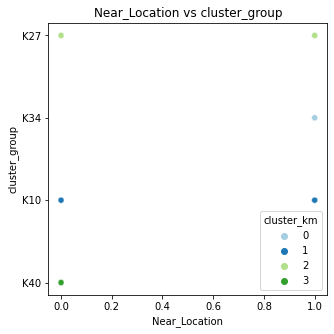

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


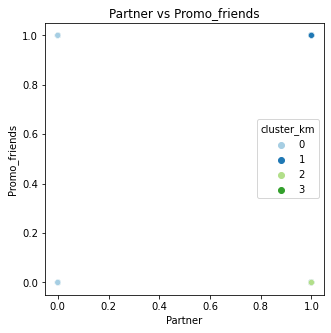

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


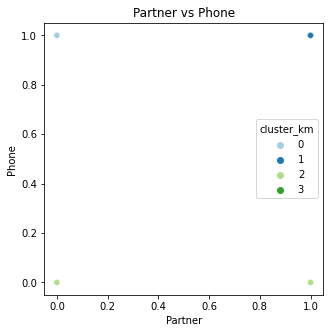

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


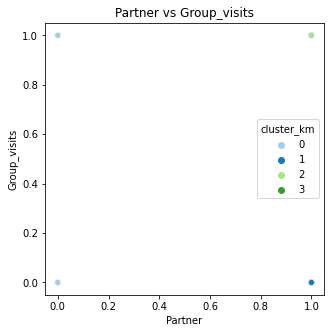

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


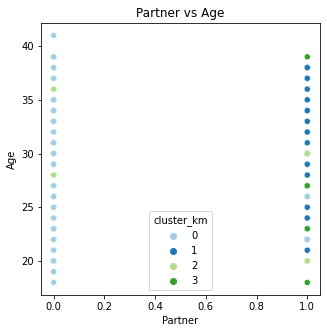

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


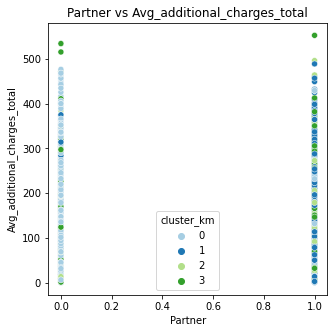

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


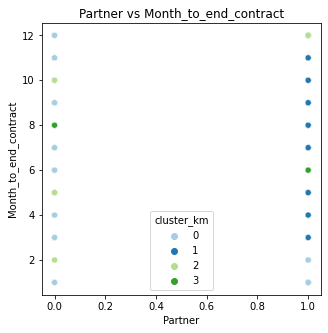

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


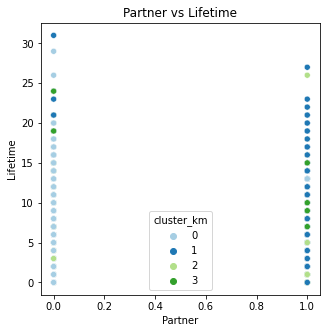

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


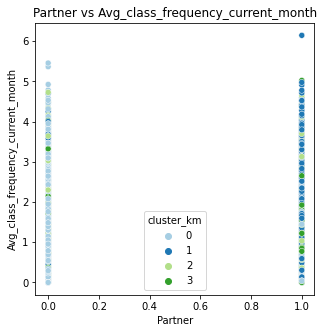

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


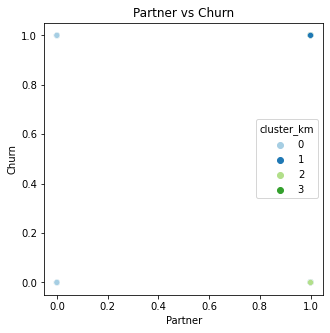

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


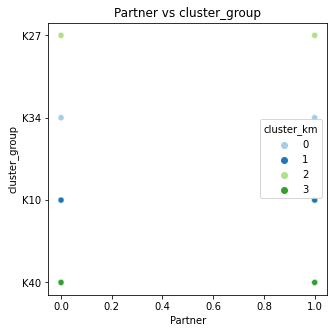

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


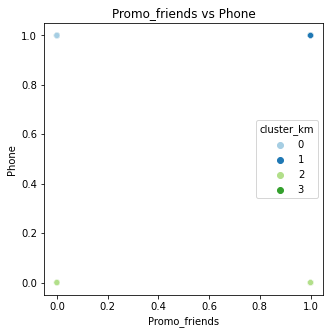

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


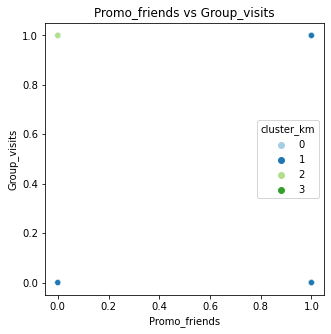

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


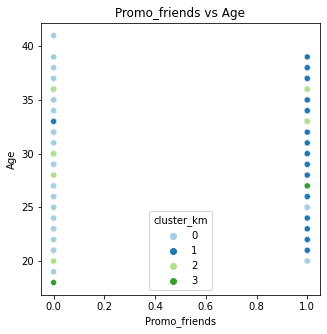

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


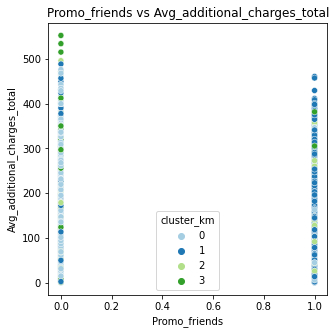

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


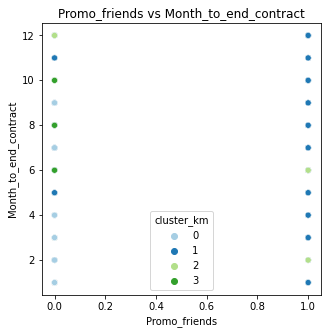

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


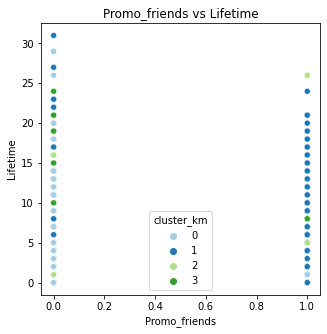

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


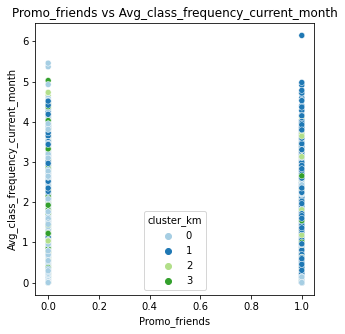

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


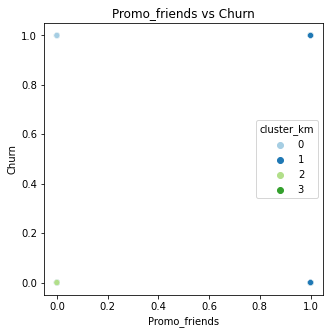

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


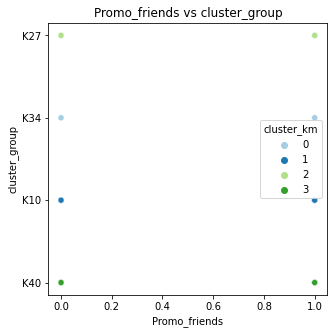

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


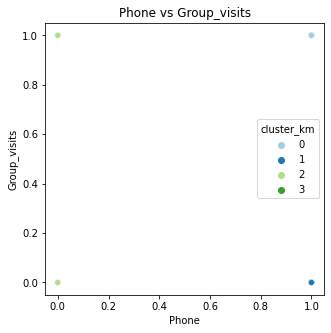

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


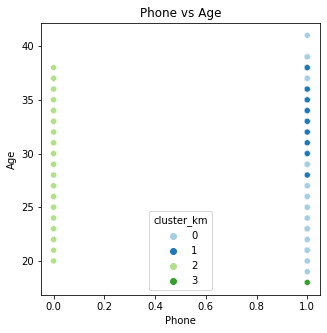

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


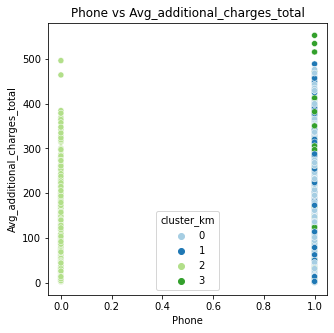

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


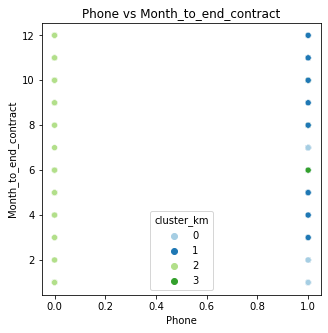

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


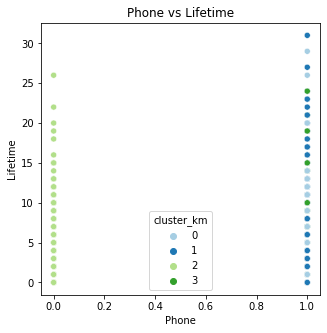

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


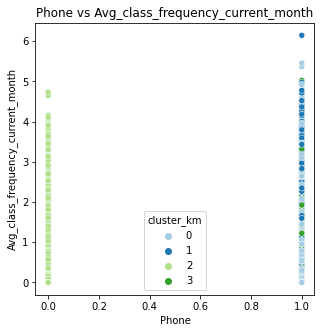

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


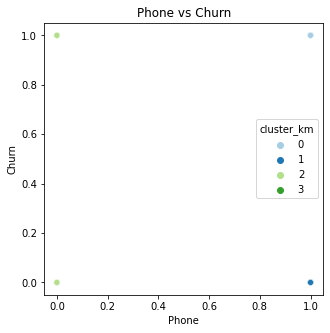

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


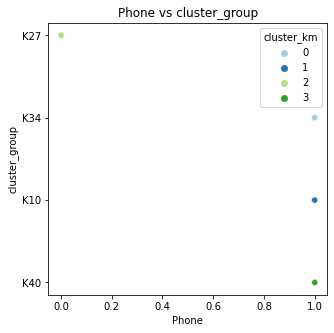

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


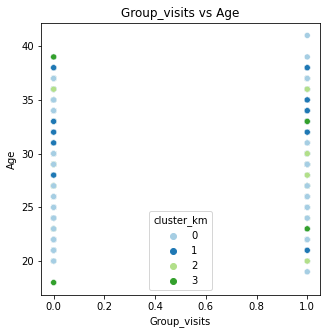

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


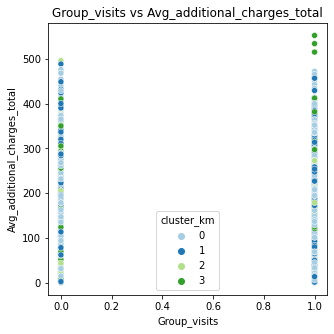

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


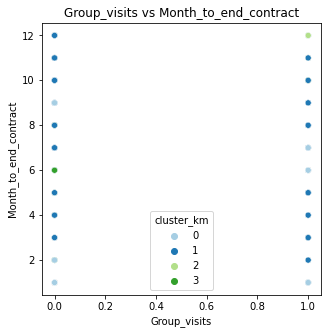

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


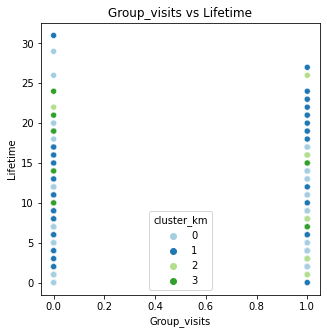

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


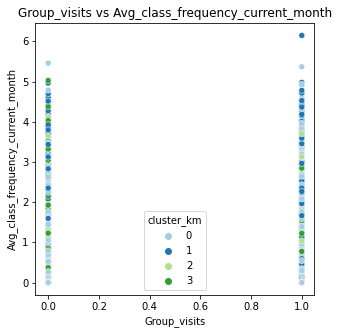

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


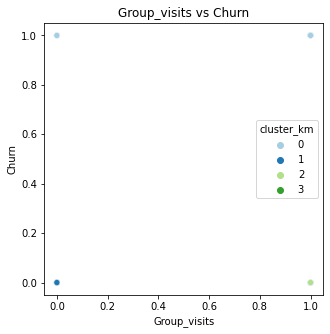

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


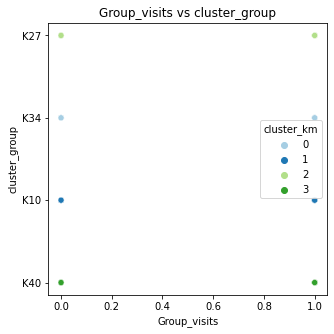

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


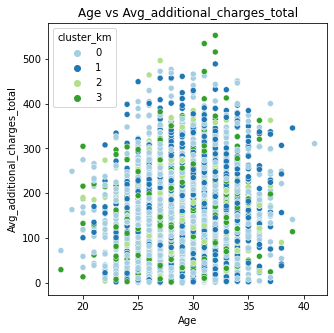

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


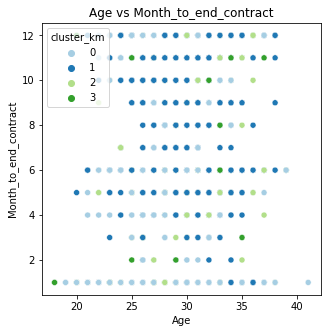

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


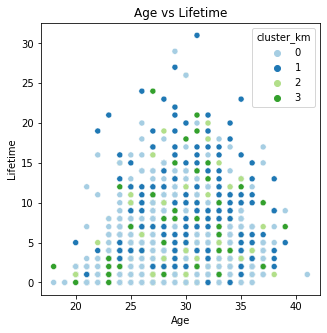

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


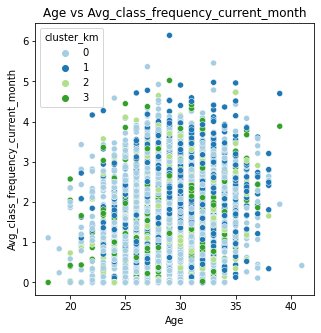

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


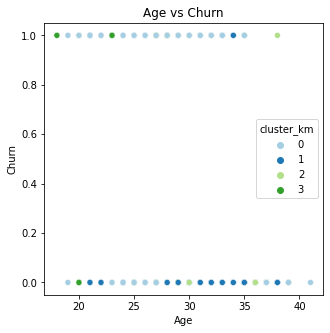

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


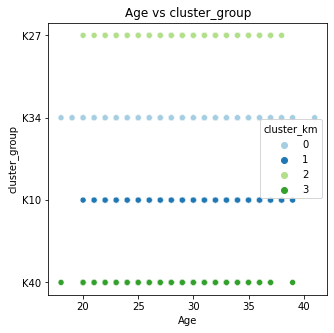

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


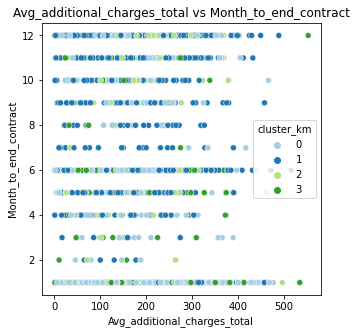

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


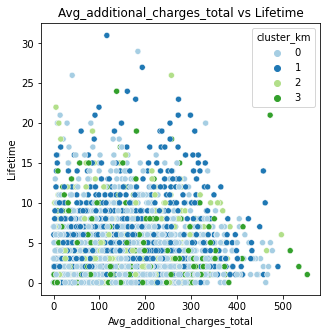

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


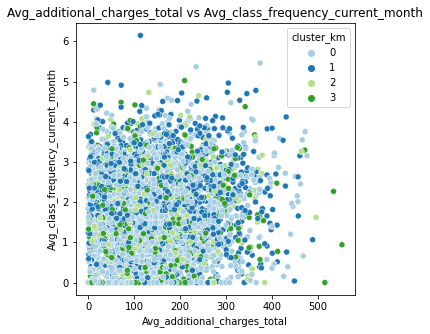

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


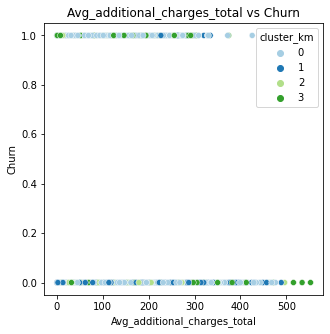

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


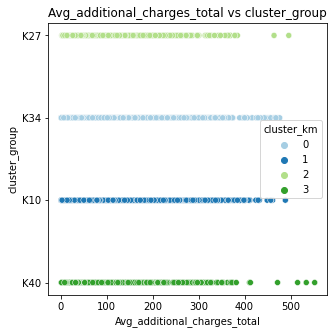

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


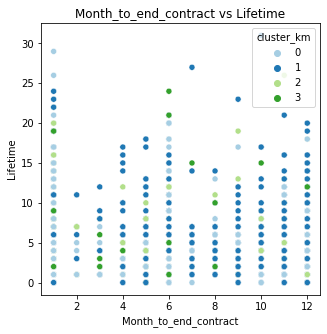

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


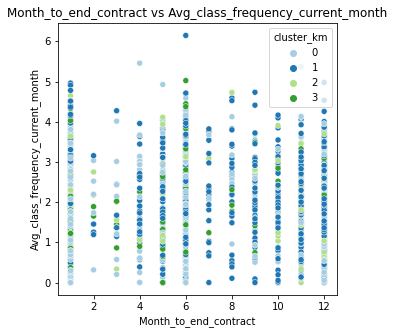

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


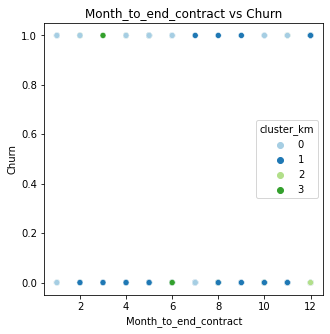

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


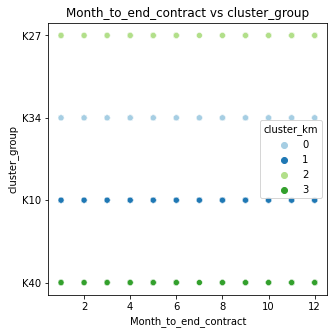

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


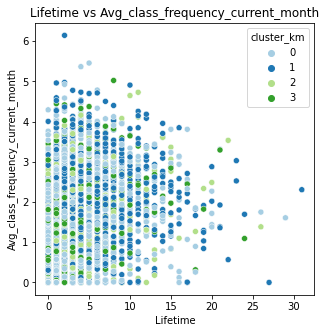

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


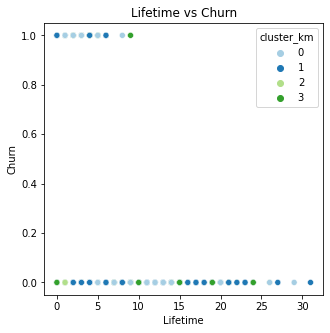

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


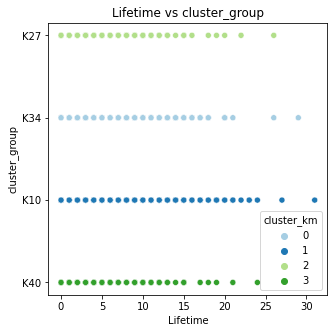

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


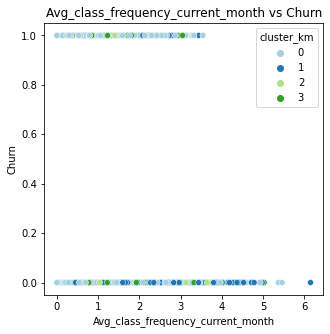

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


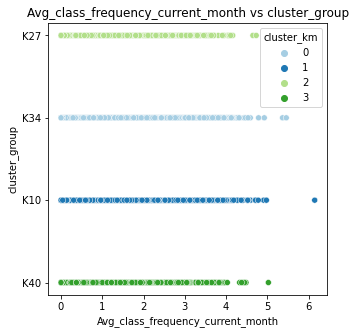

D:\Study\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


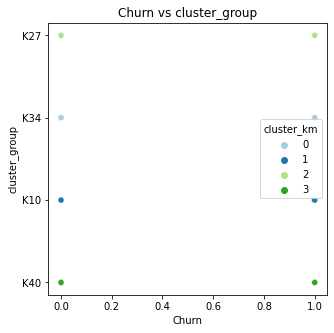

In [41]:
# определим функцию отрисовки графиков попарных признаков для кластеров
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        df[x_name], df[y_name], hue=df[cluster_name], palette='Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()
    
# отрисуем графики для попарных сочетаний признаков с разметкой по кластерам
col_pairs = list(itertools.combinations(df.drop('cluster_km', axis=1).columns, 2))
for pair in col_pairs:
    show_clusters_on_plot(df, pair[0], pair[1], 'cluster_km')    

В целом можно сказать, что на отдельных признаках заметны границы кластеров сильнее, чем на других. Низкая общая посещаемость и недавний срок (lifetime) чаще у 2 и 3-го кластера. По возрасту/общей посещаемости можно заметить, что клиенты 1-го и 5-го кластера имеют равномерную по возрасту высокую посещаемость, можно сказать, стабильные. Низкая посещаемость за текущий месяц больше свойственная 3 и 4-му кластеру

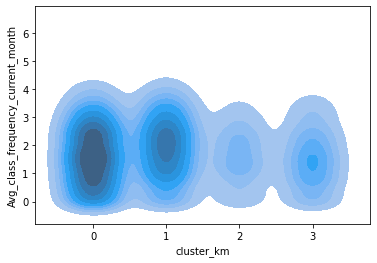

In [42]:
sns.kdeplot(data=df, y='Avg_class_frequency_current_month', x='cluster_km', fill=True)
plt.show()

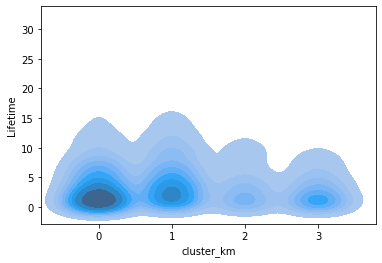

In [43]:
sns.kdeplot(data=df, y='Lifetime', x='cluster_km', fill=True)
plt.show()

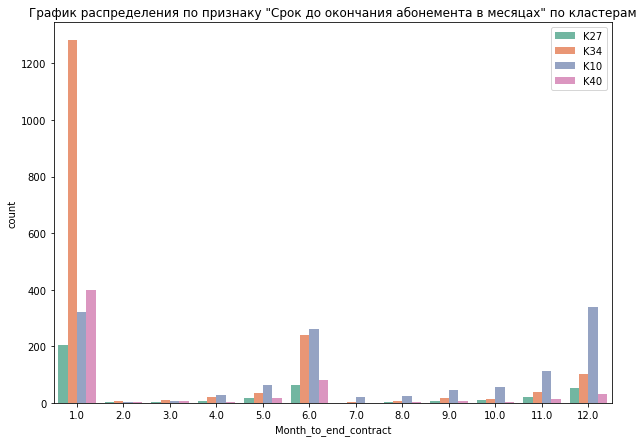

In [44]:
plt.figure(figsize=(10,7))
sns.countplot(x='Month_to_end_contract', hue='cluster_group', data=df, palette="Set2")
plt.title('График распределения по признаку "Срок до окончания абонемента в месяцах" по кластерам')
plt.legend()
plt.show()

Отмечаю также и на графике хаарктерную особенность кластера K34 - малый срок до окончания абонемента

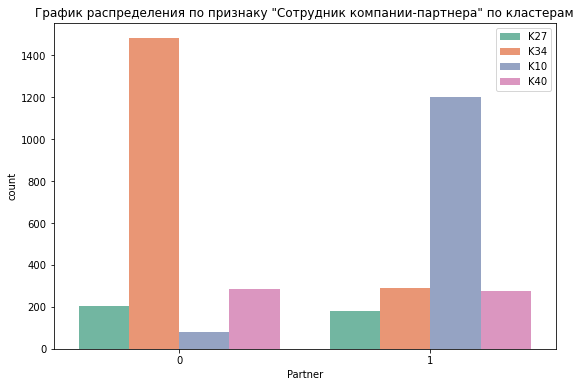

In [45]:
plt.figure(figsize=(9,6))
sns.countplot(x='Partner', hue='cluster_group', data=df, palette="Set2")
plt.title('График распределения по признаку "Сотрудник компании-партнера" по кластерам')
plt.legend()
plt.show()

В кластере К10 стабильно много сотрудников компаний-партнеров, что не характерно для кластера К34


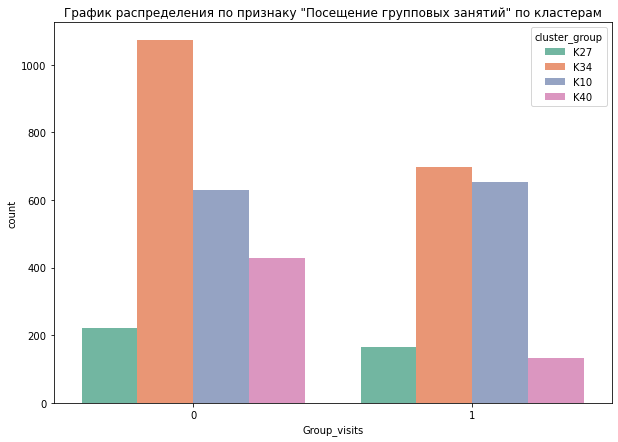

In [46]:
plt.figure(figsize=(10,7))
sns.countplot(x='Group_visits', hue='cluster_group', data=df, palette="Set2")
plt.title('График распределения по признаку "Посещение групповых занятий" по кластерам')
plt.show()

С групповыми занятиями похуже у кластеров К34 и К40. Кластеры К10 выглядит стабильно на этом признаке

### Доля оттока по кластерам

Посчитаю долю оттока по кластерам, используя группировку по кластерам и метод mean() для подсчета доли(так как отток выражен значениями 0 и 1, среднее покажет долю оттока в группе)

In [47]:
df.groupby('cluster_group')['Churn'].mean().round(2).to_frame()

,Churn
cluster_group,
K10,0.10
K27,0.27
K34,0.34
K40,0.40


Кластеры отличаются по доле оттока

Дополнительно применяю метрику кластеризации, которая анализирует компактность, кучность, отделимость кластеров

In [48]:
silhouette_score(x_sc, labels).round(3)


0.165

Учитывая, что данная метрика принимает значения от -1 до 1, где чем ближе 1, чем качественнее кластеризация, скажем, что уровень показателя кластеризации средний

### Общий вывод по шагу 4

В шаге 4 реализована модель обучения без учителя: кластеризация и K-means. Можно увидеть взаимосвязи по признакам, влиящие на отток. Тем не менее нельзя сказать, что кластеризация предсказывает с высокой точностью. Метрика силуэт - 0.16

## Шаг. Выводы и базовые рекомендации

Выводы:

- В исследовании были применены модели обучения с учителем и без учителя. По метрикам среди модели обучения с учителем лучшие показатели и модели Случайный лес
- В обучении без учителя были применены кластеризация и К-средних (K-means). Кластеризация предложила оптимальное число кластеров: 4. Для K-means было предложено делить на 5 кластеров. Статистика по кластерам в средних значениях, а также попарные графики признаков показали различие признаков в кластерах
- Была посчитана доля оттока для кластеров. Высокий отток свойственен кластерам K34 и K40

Рекомендуется обратить внимание на такие признаки как:
- средняя посещаемость за все время и средняя посещаемость за текущий месяц. Больший отток замечен там, где текущая посещаемость снижается
- срок до окончания абонемента(month_to_end_contract)
- срок с первого обращения(lifetime) Чем дольше человек в клубе, тем меньше вероятность оттока
- Посещений групповых занятий. В группах оттока посещение уменьшается
- Компания-партнер. Вероятность оттока значительно выше, если клиент не является сотрдуником компании-партнера